In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from eg3d_dataset import EG3DDataset, EG3DImageProcessor
from PIL import Image
import numpy as np

2023-04-18 15:32:28.386097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:32:28.624166: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset = EG3DDataset('data', triplanes=True, latent_triplanes=True, transform=EG3DImageProcessor())

In [3]:
dataset[0]['triplanes'].shape

torch.Size([96, 256, 256])

In [4]:
from autoencoder import AutoencoderKLConfig, AutoencoderKL
from eg3d import EG3D

In [5]:
eg3d = EG3D('eg3d/eg3d_model/ffhqrebalanced512-128.pkl', device='cuda', render_only=True)

# ae_conf = AutoencoderKLConfig(ch=512, ch_mult = [ 1,2,4 ])
# ae = AutoencoderKL(ae_conf)

In [7]:
ckpt_pth = '/scratch/korte/ae.ckpt'
# ckpt_pth = '/scratch1/korte/eg3d-latent-diffuser/autoencoder/lightning_logs/version_1/checkpoints/autoencoder-epoch=254-val_loss=0.00.ckpt'
# weights = torch.load(ckpt_pth, map_location="cpu")
ae = AutoencoderKL.load_from_checkpoint(ckpt_pth, strict=False)
# ae.init_from_ckpt()

making attention of type 'vanilla' with 2048 in_channels
Working with z of shape (1, 128, 64, 64) = 524288 dimensions.
making attention of type 'vanilla' with 2048 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [ ]:
ae.encoder

In [8]:
aec = ae.to('cuda')

In [8]:
triplanes = eg3d.generate_random_planes(reshape=False)[0]

In [19]:
planes = torch.empty((4,96,256,256))
for i in range(2):
    planes[i] = dataset[0]['triplanes']
planes = planes.to('cuda')

In [30]:
%%time
with torch.no_grad():
    aec.encode(planes)

CPU times: user 6.34 ms, sys: 54 µs, total: 6.39 ms
Wall time: 5.21 ms


In [8]:
with torch.no_grad():
    aec.encode(dataset[0]['triplanes'].unsqueeze(0).to('cuda'))

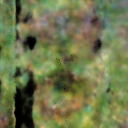

In [12]:
tri_img = eg3d.render_planes(triplanes.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
tri_img = Image.fromarray(((tri_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(tri_img)

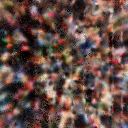

In [15]:
tri_img = eg3d.render_planes(triplanes.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
tri_img = Image.fromarray(((tri_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(tri_img)

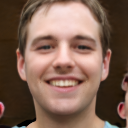

In [13]:
with torch.no_grad():
    out = aec(triplanes.to('cuda'))[0]
ae_img = eg3d.render_planes(out, None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

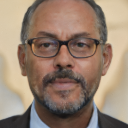

In [12]:
ae_img = eg3d.render_planes(dataset[0]['triplanes'].unsqueeze(0).to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

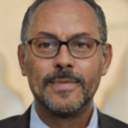

In [10]:
with torch.no_grad():
    dec = aec(dataset[0]['triplanes'].unsqueeze(0).to('cuda'))[0]
ae_img = eg3d.render_planes(dec.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

In [6]:
from diffuser import TRIAD

In [ ]:
diffuser = TRIAD.load_from_checkpoint('/scratch/korte/dif.ckpt')

In [8]:
diffuser = diffuser.to('cuda')

In [13]:
triplanes = diffuser.gen_triplanes(images=dataset[0]['images'].unsqueeze(0), num_triplanes=1, num_timesteps=5000)

  0%|          | 0/5009 [00:00<?, ?it/s]

In [31]:
print(triplanes[0][0])

tensor([[25.3290, 36.7711, 37.4073,  ..., 51.3480, 48.2621, 31.5864],
        [39.1938, 56.8168, 58.0026,  ..., 78.1491, 74.2807, 49.1941],
        [44.0539, 64.2612, 66.7376,  ..., 86.4158, 82.4294, 55.1048],
        ...,
        [34.2050, 54.3253, 66.8817,  ..., 51.5181, 47.5800, 30.7823],
        [30.3692, 48.0837, 58.6899,  ..., 54.4918, 50.1143, 32.2568],
        [20.3982, 32.3645, 39.4096,  ..., 40.6389, 36.6160, 23.2050]],
       device='cuda:0')


In [33]:
dataset[0]['triplanes'][0]

tensor([[28.0769, 35.4929, 36.8728,  ..., 30.9076, 28.7465, 20.0828],
        [35.3652, 41.6902, 39.6789,  ..., 35.7923, 35.8429, 27.8365],
        [36.7615, 40.2052, 38.4067,  ..., 37.0662, 36.8216, 29.2272],
        ...,
        [35.8235, 42.4590, 44.0384,  ..., 55.6399, 52.3662, 44.6820],
        [35.0700, 42.9043, 43.3274,  ..., 54.5682, 52.4758, 42.0530],
        [27.7086, 36.8223, 40.1732,  ..., 47.0964, 44.2010, 31.4209]])

In [57]:
from diffusers import PNDMScheduler
test_scheduler = PNDMScheduler(num_train_timesteps=1000)

In [58]:
with torch.no_grad():
    encoded_images = diffuser.encode_images(dataset[0]['images'].unsqueeze(0).to('cuda'))
    encoded_triplanes = diffuser.encode_triplanes(dataset[0]['triplanes'].unsqueeze(0).to('cuda')).sample()
    noise = torch.randn((1,128,64,64)).to('cuda')
    # timesteps = torch.randint(0, diffuser.noise_scheduler.num_train_timesteps, (1,), device='cuda').long()
    timesteps = torch.tensor(999).long()
    print(timesteps)

    noisy_triplanes = test_scheduler.add_noise(encoded_triplanes, noise, timesteps)

    pred_noise = diffuser(noisy_triplanes, timesteps, encoded_images, return_dict=True)[0]

    loss = F.mse_loss(pred_noise, noise)
    print(loss)

tensor(999)
tensor(0.0084, device='cuda:0')


In [65]:
encoded_triplanes[0][0]

tensor([[-0.1090, -1.1625, -1.0754,  ..., -1.1303, -1.3766, -1.3274],
        [-1.2374, -1.6431, -1.0648,  ..., -0.9582, -1.8897, -0.6376],
        [-1.5922, -1.0388, -0.0690,  ...,  0.0942, -1.2179, -0.3805],
        ...,
        [-1.0851, -1.7106, -1.2586,  ..., -1.3043, -1.7364, -0.8957],
        [-0.8075, -2.0636, -1.7855,  ..., -1.9607, -2.1004, -1.0822],
        [-0.4280, -1.1987, -1.3225,  ..., -1.3831, -2.2421, -0.4719]],
       device='cuda:0')

In [66]:
noisy_triplanes[0][0]

tensor([[ 2.9340,  1.5378, -0.4459,  ...,  0.5846,  1.0472, -0.3335],
        [-0.1410, -0.3449, -2.0901,  ...,  1.2631,  0.5894, -0.3413],
        [ 0.1372,  0.0753,  0.3500,  ..., -1.4504,  1.1215, -0.0274],
        ...,
        [-1.2131, -0.9704, -0.9651,  ..., -0.8283,  1.0827, -0.0131],
        [ 0.1588,  1.0650, -0.8106,  ..., -1.2456,  1.1631,  1.9567],
        [-1.4134,  0.8942,  0.3791,  ..., -0.2984, -0.2609,  1.3156]],
       device='cuda:0')

In [59]:
decoded_triplanes_noisy = diffuser.ae.decode(noisy_triplanes)
decode_noise = diffuser.ae.decode(noise)

In [44]:
with torch.no_grad():
    encoded_triplanes = diffuser.encode_triplanes(dataset[0]['triplanes'].unsqueeze(0).to('cuda')).sample()
    triplanes = diffuser.ae.decode(encoded_triplanes)

In [30]:
F.mse_loss(triplanes[0].cpu(), dataset[0]['triplanes'])

tensor(2989.5781)

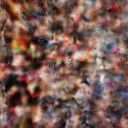

In [60]:
ae_img = eg3d.render_planes(decode_noise.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

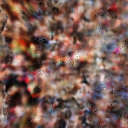

In [61]:
ae_img = eg3d.render_planes(decoded_triplanes_noisy.to('cuda'), None, reshape_planes=True)[0].cpu().detach().numpy()
ae_img = Image.fromarray(((ae_img + 1) / 2 * 255).astype(np.uint8).clip(0, 255))
display(ae_img)

In [7]:
# TESTING AUTOGRAD VRAM
triplanes = dataset[0]['triplanes'].unsqueeze(0).to('cuda')
out = aec(triplanes, 0)

In [4]:
from diffusers import UNet2DConditionModel

2023-04-09 17:21:22.177600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 17:21:22.260694: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
diffuser = UNet2DConditionModel(
    sample_size=64,
    in_channels=128,
    out_channels=128,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(320, 640, 1280, 1280),  # the number of output channes for each UNet block
    down_block_types = ('CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D'),
    up_block_types = ('UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D'),
)

In [14]:
et = ae.encode(dataset[0]['triplanes'].unsqueeze(0))

In [20]:
dataset[0]['triplanes'].unsqueeze(0).shape

torch.Size([1, 96, 256, 256])

In [19]:
ets = et.sample()
ets.shape

torch.Size([1, 4, 32, 32])

In [ ]:
diffuser(dataset[0]['triplanes'].unsqueeze(0), 1, torch.tensor([10, 11, 12]))

In [ ]:
diffuser = diffuser.to('cuda')

In [10]:
with torch.no_grad():
    out = diffuser.diffuser(torch.zeros(1, 128, 64, 64).to('cuda'), 1, torch.zeros((1,1,1024)).to('cuda')).sample
out

tensor([[[[-0.0769, -0.0519, -0.0711,  ..., -0.0949, -0.0447,  0.1937],
          [ 0.0079, -0.0367, -0.0707,  ..., -0.0702, -0.0195,  0.0382],
          [ 0.0126, -0.0351, -0.0485,  ..., -0.0397, -0.0095,  0.0341],
          ...,
          [-0.0333, -0.0267, -0.0080,  ..., -0.0560, -0.0395, -0.0696],
          [-0.0489, -0.0612, -0.0349,  ..., -0.0478, -0.0252, -0.0633],
          [-0.0236,  0.0293,  0.0199,  ...,  0.0286,  0.0175, -0.1683]],

         [[-0.0338, -0.0161,  0.0185,  ...,  0.0206,  0.0269, -0.0317],
          [ 0.0080, -0.1537, -0.0147,  ..., -0.0116, -0.0048, -0.0569],
          [ 0.0096, -0.1016, -0.0675,  ..., -0.0238, -0.1316, -0.0571],
          ...,
          [ 0.0547,  0.0144,  0.0888,  ...,  0.0383,  0.1165,  0.0268],
          [ 0.0942, -0.0496, -0.0412,  ...,  0.0506,  0.1372, -0.0154],
          [-0.0709, -0.0120, -0.0103,  ..., -0.0116, -0.0172,  0.0135]],

         [[ 0.0632,  0.0596,  0.0108,  ...,  0.0445,  0.0336,  0.1807],
          [ 0.0803,  0.0813,  

In [10]:
lf = torch.nn.SmoothL1Loss()
lf(out, torch.ones(out.shape, device='cuda')).backward()


In [57]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

In [58]:
repo_id = "stabilityai/stable-diffusion-2-base"
# repo_id = "stabilityai/stable-diffusion-x4-upscaler"
pipe = DiffusionPipeline.from_pretrained(repo_id)#, torch_dtype=torch.float16, revision="fp16")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/korte/micromamba/envs/eg3d/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [59]:
pipe.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.12.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}

In [10]:
pipe.unet.block_out_channels

[320, 640, 1280, 1280]

In [7]:
pipe.text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1024)
      (position_embedding): Embedding(77, 1024)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-22): 23 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,

In [28]:
pipe.vae.decoder

Decoder(
  (conv_in): Conv2d(4, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_blocks): ModuleList(
    (0-1): 2 x UpDecoderBlock2D(
      (resnets): ModuleList(
        (0-2): 3 x ResnetBlock2D(
          (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
          (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (upsamplers): ModuleList(
        (0): Upsample2D(
          (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): UpDecoderBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
          (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [34]:
pipe.vae.encode(torch.zeros((1, 3, 512, 512),)).latent_dist

In [6]:
pipe.vae.decode(torch.zeros((1, 4, 64, 64))).sample[0][0][0][0]

tensor(0.0427, grad_fn=<SelectBackward0>)

In [12]:
from diffusers import AutoencoderKL
vae = AutoencoderKL(in_channels=96, latent_channels=128, out_channels=96)
vae = vae.to('cuda')

In [13]:
out = vae.encode(dataset[0]['triplanes'].unsqueeze(0).to('cuda'))

In [8]:
out

AutoencoderKLOutput(latent_dist=<diffusers.models.vae.DiagonalGaussianDistribution object at 0x154fc5eacca0>)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
f0 = nn.Linear(5, 5)

f1 = nn.Linear(5, 5)
out = f1(f0(torch.zeros(1, 5)))

f2 = nn.Linear(5, 5)
out2 = f2(f0(torch.zeros(1, 5)))

loss = F.mse_loss(out, torch.zeros(1, 5))
loss.backward()

loss2 = F.mse_loss(out2, torch.zeros(1, 5))
loss2.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.